In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb


In [13]:
df = pd.read_csv('paintings_dataset.csv')
train_df = pd.read_csv('paintings_dataset_train.csv')
test_df = pd.read_csv('paintings_dataset_test.csv')

## Explaratory Data Analysis (EDA)

movement
High Renaissance                    146
Baroque                             100
Impressionism                        98
Italian Renaissance                  86
Dutch Golden Age painting            83
                                   ... 
Neue Künstlervereinigung München      1
Vienna Secession                      1
The Blue Rider                        1
Newlyn School                         1
Rococo painting                       1
Name: count, Length: 86, dtype: int64

Number of unique movements in the data: 86


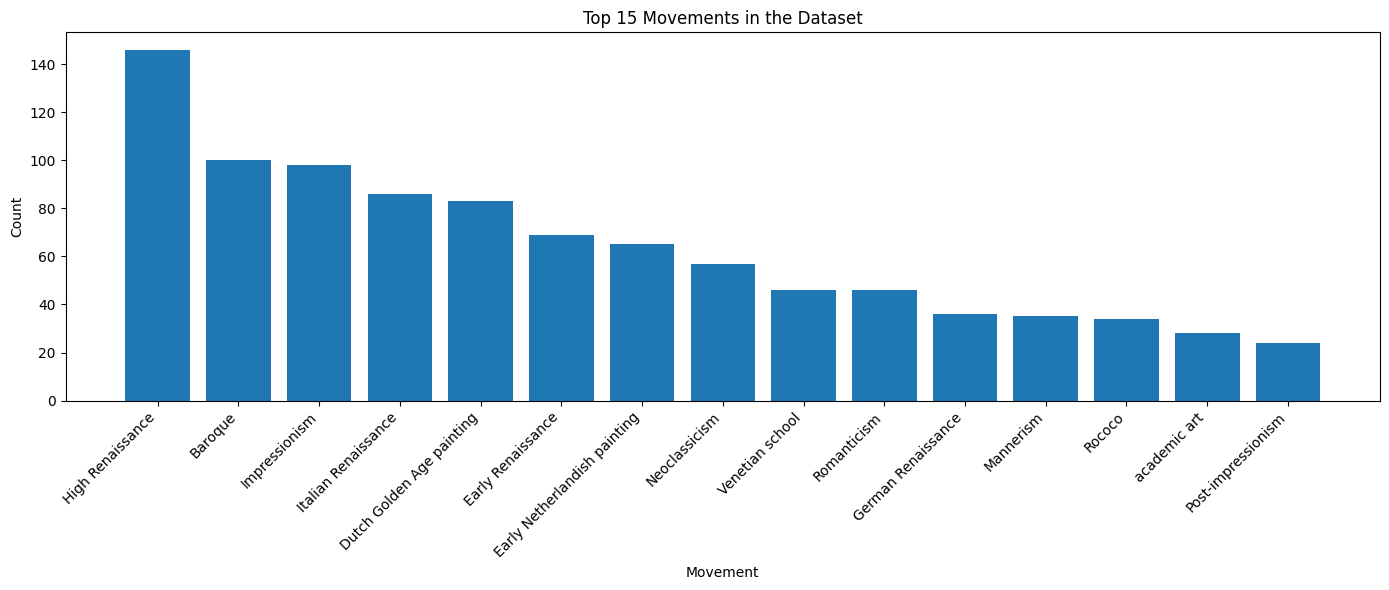

In [14]:
print(df['movement'].value_counts())
print(f"\nNumber of unique movements in the data: {df['movement'].nunique()}")


fig, axes = plt.subplots(1, 1, figsize=(14, 6))

df_counts = df['movement'].value_counts()
axes.bar(range(len(df_counts.head(15))), df_counts.head(15).values)
axes.set_title('Top 15 Movements in the Dataset')
axes.set_xlabel('Movement')
axes.set_ylabel('Count')
axes.set_xticks(range(len(df_counts.head(15))))
axes.set_xticklabels(df_counts.head(15).index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Feature Engineering

In [33]:
def create_features(df):
    df = df.copy()
    numerical_features = ['year', 'height', 'width']

    for col in numerical_features:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Create derived features
    df['aspect_ratio'] = df['width'] / df['height']
    df['area'] = df['height'] * df['width']
    df['diagonal'] = np.sqrt(df['height']**2 + df['width']**2)
    df['aspect_ratio'] = df['aspect_ratio'].replace([np.inf, -np.inf], 1.0)

    # Time features
    df['century'] = (df['year'] // 100) * 100
    df['half_century'] = (df['year'] // 50) * 50

    # Size features
    df['size_category'] = pd.cut(df['area'],
                                  bins=[0, 1000, 5000, 20000, np.inf],
                                  labels=['tiny', 'small', 'medium', 'large'])

    return df

train_df_fe = create_features(train_df)
test_df_fe = create_features(test_df)

## Data proccessing

In [35]:
def prepare_data(train_df, test_df):
    numerical_features = ['year', 'height', 'width', 'aspect_ratio', 'area', 'diagonal']
    categorical_features = ['artist', 'medium']

    label_encoders = {}
    X_train = train_df[numerical_features].copy()

    # Encode categorical features for training
    for col in categorical_features:
        if col in train_df.columns:
            le = LabelEncoder()
            all_data = pd.concat([train_df[col].fillna('Unknown'),
                                  test_df[col].fillna('Unknown')])
            le.fit(all_data)
            X_train[f'{col}_encoded'] = le.transform(train_df[col].fillna('Unknown'))
            label_encoders[col] = le

    X_test = test_df[numerical_features].copy()

    # Encode categorical features for test
    for col in categorical_features:
        if col in test_df.columns:
            le = label_encoders[col]
            X_test[f'{col}_encoded'] = le.transform(test_df[col].fillna('Unknown'))

    # Encode target
    le_target = LabelEncoder()
    all_movements = pd.concat([train_df['movement'], test_df['movement']]).fillna('Unknown')
    le_target.fit(all_movements)

    y_train = le_target.transform(train_df['movement'].fillna('Unknown'))
    y_test = le_target.transform(test_df['movement'].fillna('Unknown'))

    return X_train, X_test, y_train, y_test, le_target, label_encoders

X_train, X_test, y_train, y_test, le_target, label_encoders = prepare_data(train_df_fe, test_df_fe)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Training the models

In [50]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'SVM': SVC(
        random_state=42,
        C=1.0,
        kernel='rbf',
        probability=True,
        class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced'
    ),
    'MLP Neural Network': MLPClassifier(
        random_state=42,
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        early_stopping=True
    )
}

results = {}
predictions = {}
training_times = {}

for name, model in models.items():
    import time
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time
    }

    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Training Time: {training_time:.2f}s")

Gradient Boosting Results:
  Test Accuracy: 0.6833
  Test F1-Score: 0.6722
  CV Accuracy: 0.6182 (+/- 0.0194)
  Training Time: 55.06s
Random Forest Results:
  Test Accuracy: 0.4542
  Test F1-Score: 0.4470
  CV Accuracy: 0.4278 (+/- 0.0306)
  Training Time: 0.51s
SVM Results:
  Test Accuracy: 0.1625
  Test F1-Score: 0.1719
  CV Accuracy: 0.1035 (+/- 0.0422)
  Training Time: 0.95s
K-Nearest Neighbors Results:
  Test Accuracy: 0.5417
  Test F1-Score: 0.5137
  CV Accuracy: 0.5345 (+/- 0.0258)
  Training Time: 0.00s
Logistic Regression Results:
  Test Accuracy: 0.1250
  Test F1-Score: 0.1184
  CV Accuracy: 0.1014 (+/- 0.0227)
  Training Time: 0.59s
MLP Neural Network Results:
  Test Accuracy: 0.4167
  Test F1-Score: 0.3377
  CV Accuracy: 0.3766 (+/- 0.0219)
  Training Time: 0.96s


In [52]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)
print(results_df.round(4))

                     accuracy  f1_score  cv_mean  cv_std  training_time
Gradient Boosting      0.6833    0.6722   0.6182  0.0194        55.0634
K-Nearest Neighbors    0.5417    0.5137   0.5345  0.0258         0.0023
Random Forest          0.4542    0.4470   0.4278  0.0306         0.5134
MLP Neural Network     0.4167    0.3377   0.3766  0.0219         0.9628
SVM                    0.1625    0.1719   0.1035  0.0422         0.9464
Logistic Regression    0.1250    0.1184   0.1014  0.0227         0.5907


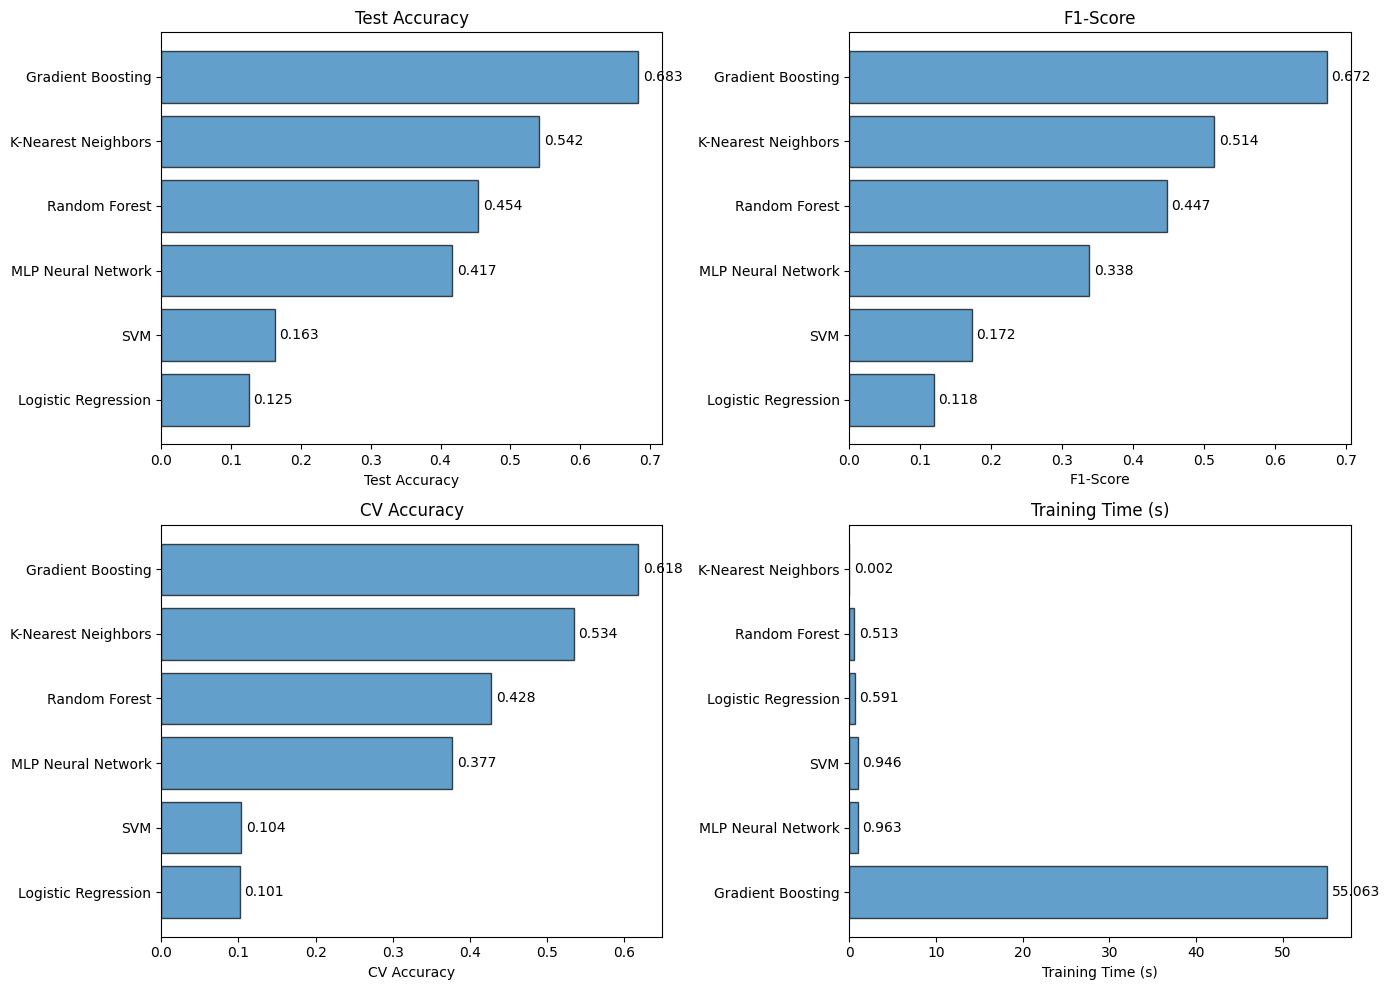

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['accuracy', 'f1_score', 'cv_mean', 'training_time']
metric_names = ['Test Accuracy', 'F1-Score', 'CV Accuracy', 'Training Time (s)']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    sorted_idx = results_df[metric].sort_values(ascending=metric != 'training_time').index
    values = results_df.loc[sorted_idx, metric]

    bars = ax.barh(range(len(values)), values, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(sorted_idx)
    ax.set_xlabel(name)
    ax.set_title(name)

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + max(values)*0.01, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()


## Error Analysis

In [66]:
movement_names = le_target.classes_
error_analysis = pd.DataFrame(index=movement_names)

for model_name in results_df.index:
    y_pred = predictions[model_name]['y_pred']

    movement_accuracy = []
    for movement_idx, movement_name in enumerate(movement_names):
        mask = (y_test == movement_idx)
        if mask.any():
            movement_correct = (y_pred[mask] == movement_idx).sum()
            movement_total = mask.sum()
            movement_accuracy.append(movement_correct / movement_total)
        else:
            movement_accuracy.append(np.nan)

    error_analysis[model_name] = movement_accuracy

error_analysis['std'] = error_analysis[results_df.index].std(axis=1)
error_analysis['mean'] = error_analysis[results_df.index].mean(axis=1)


In [63]:
error_df = pd.DataFrame({
    'true_movement': le_target.inverse_transform(y_test),
    'year': test_df_fe['year'],
    'height': test_df_fe['height'],
    'width': test_df_fe['width'],
    'area': test_df_fe['area'],
    'aspect_ratio': test_df_fe['aspect_ratio'],
    'artist': test_df_fe['artist'],
    'medium': test_df_fe['medium']
})

best_model_name = results_df.index[0]
error_df['pred_movement'] = le_target.inverse_transform(predictions[best_model_name]['y_pred'])
error_df['is_correct'] = error_df['true_movement'] == error_df['pred_movement']


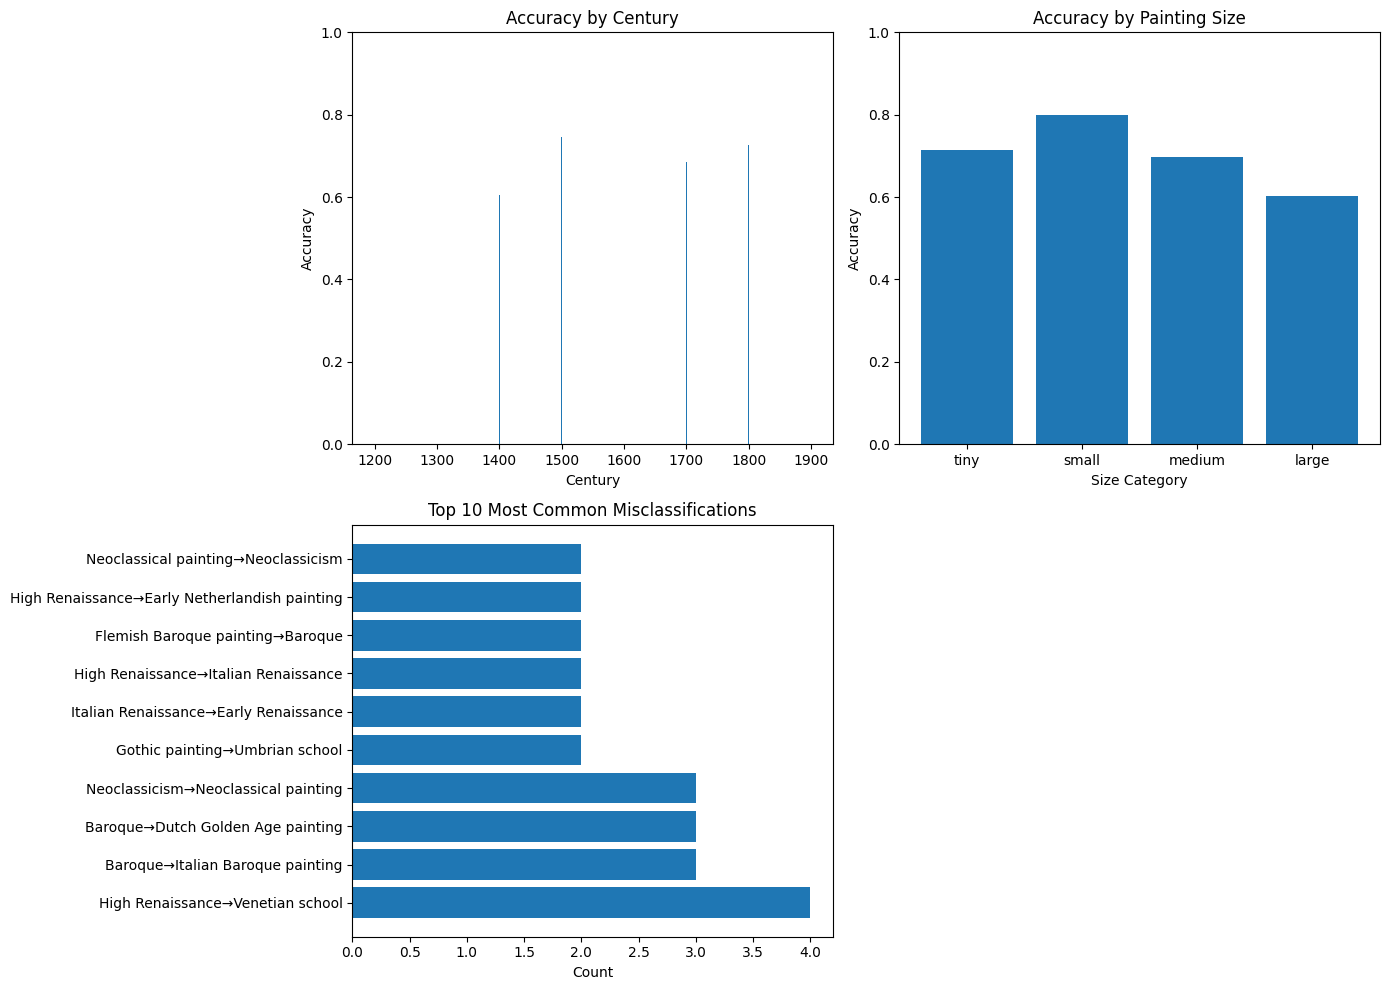

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

error_df['century'] = (error_df['year'] // 100) * 100
accuracy_by_century = error_df.groupby('century')['is_correct'].mean()
axes[0,0].bar(accuracy_by_century.index, accuracy_by_century.values)
axes[0,0].set_title('Accuracy by Century')
axes[0,0].set_xlabel('Century')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim([0, 1])

error_df['size_category'] = pd.cut(error_df['area'],
                                   bins=[0, 1000, 5000, 20000, np.inf],
                                   labels=['tiny', 'small', 'medium', 'large'])
accuracy_by_size = error_df.groupby('size_category')['is_correct'].mean()
axes[0,1].bar(range(len(accuracy_by_size)), accuracy_by_size.values)
axes[0,1].set_title('Accuracy by Painting Size')
axes[0,1].set_xlabel('Size Category')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_xticks(range(len(accuracy_by_size)))
axes[0,1].set_xticklabels(accuracy_by_size.index)
axes[0,1].set_ylim([0, 1])

misclass = error_df[~error_df['is_correct']]
misclass_pairs = misclass.groupby(['true_movement', 'pred_movement']).size().reset_index(name='count')
misclass_pairs = misclass_pairs.sort_values('count', ascending=False).head(10)

axes[1,0].barh(range(len(misclass_pairs)), misclass_pairs['count'])
axes[1,0].set_yticks(range(len(misclass_pairs)))
axes[1,0].set_yticklabels([f"{t}→{p}" for t, p in zip(misclass_pairs['true_movement'], misclass_pairs['pred_movement'])])
axes[1,0].set_title('Top 10 Most Common Misclassifications')
axes[1,0].set_xlabel('Count')

axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()


## Model Comparison

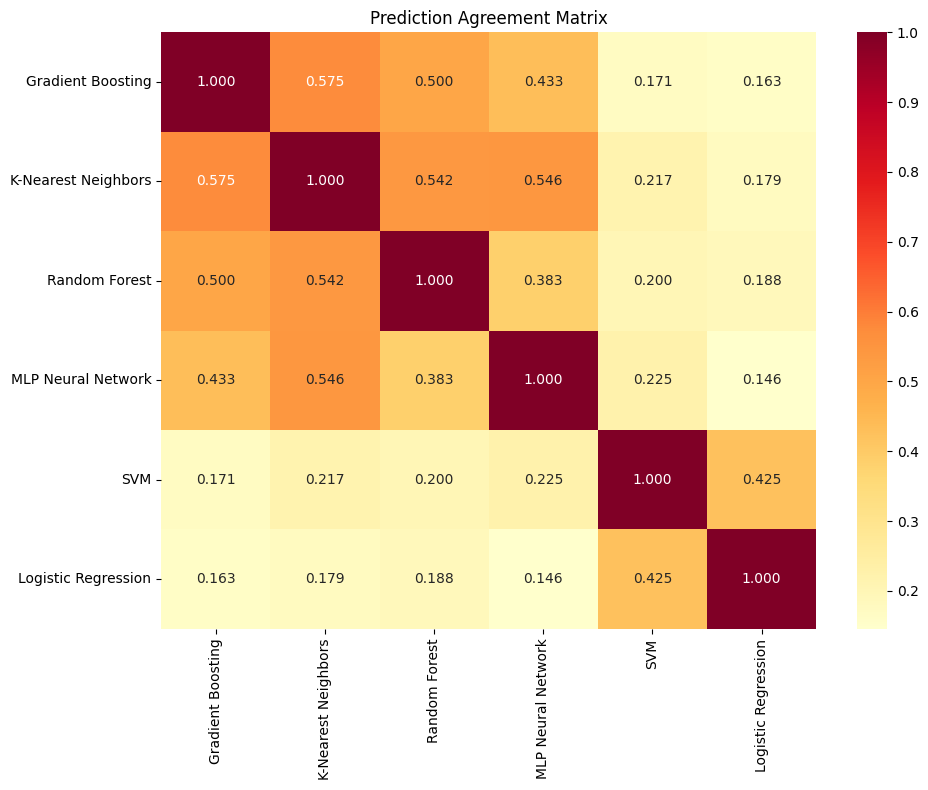

In [57]:
n_models = len(results_df)
agreement_matrix = np.zeros((n_models, n_models))
model_names = list(results_df.index)

for i, model_i in enumerate(model_names):
    for j, model_j in enumerate(model_names):
        if i <= j:
            pred_i = predictions[model_i]['y_pred']
            pred_j = predictions[model_j]['y_pred']
            agreement = (pred_i == pred_j).mean()
            agreement_matrix[i, j] = agreement
            agreement_matrix[j, i] = agreement

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=model_names, yticklabels=model_names)
plt.title('Prediction Agreement Matrix')
plt.tight_layout()
plt.show()

